<a href="https://colab.research.google.com/github/JulliaNascimento/Mineracao-de-Dados/blob/main/Dados_trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desenvolvimento Códigos - Trabalho de Mineração de Dados**




# **Dados**

Instalando pacotes necessários para realizar as analises

In [ ]:
install.packages("tidymodels")
install.packages("janitor")
install.packages("skimr")
install.packages("vip")
install.packages("rpart.plot")
install.packages("rpart")
install.packages("gmodels")
install.packages("C50")

Carregando os pacotes instalados anteriormente




In [8]:
library(tidyverse)
library(tidymodels)
library(janitor)
library(skimr)
library(scales)
library(gmodels)
library(vip)
library(rpart.plot)
library(rpart)
library(C50)

Carregamento dos dados e tratativa no nome das colunas

In [ ]:
dados <- read_csv2("/content/Base de Dados - Incidentes.csv",locale = locale(encoding ='ISO-8859-1'))
dados <- janitor::clean_names(dados)
#skim(dados)

Realizando tratativa dos dados, mudando as variáveis char em fatores, criando uma nova coluna que de acordo com o Estado iremos definir a região, após isso realizando a exclusão da coluna estado já que não iremos trabalhar com ela. 

Além disso substituímos os "***" por NA para que seja possível identicar os dados faltantes

In [11]:
dados <- mutate (dados,regiao = case_when(ocorrencia_uf %in% c('MG','SP','RJ','ES') ~ 'SUDESTE',
                 ocorrencia_uf %in% c('PR','RS','SC') ~ 'SUL',
                 ocorrencia_uf %in% c('MA','PI','CE','RN','PE','PB','SE','AL','BA') ~ 'NORDESTE',
                 ocorrencia_uf %in% c('MT','MS','GO','DF') ~ 'CENTRO-OESTE',
                 ocorrencia_uf %in% c('AM','RR','AP','PA','TO','RO','AC') ~ 'NORTE'),.keep='unused')

dados <- mutate(dados,
                ocorrencia_classificacao = as.factor(ocorrencia_classificacao),
                ocorrencia_saida_pista = as.factor(ocorrencia_saida_pista),
                aeronave_tipo_veiculo = as.factor(aeronave_tipo_veiculo),
                aeronave_motor_tipo = as.factor(aeronave_motor_tipo),
                aeronave_motor_quantidade = as.factor(aeronave_motor_quantidade),
                aeronave_fase_operacao = as.factor(aeronave_fase_operacao),
                aeronave_tipo_operacao = as.factor(aeronave_tipo_operacao),
                aeronave_nivel_dano = as.factor(aeronave_nivel_dano),
                regiao = as.factor(regiao)
                )
dados[dados== '***'] <- NA

## **Analise Descritiva dos Dados**

Trazendo informações referente ao conjunto de dados. Como quantidade de observações, quantidade de colunas, quantidade de dados faltantes em cada coluna entre outras informações.

In [6]:
glimpse(dados)

Rows: 5,529
Columns: 10
$ ocorrencia_classificacao   <fct> INCIDENTE GRAVE, INCIDENTE GRAVE, INCIDENTE…
$ total_aeronaves_envolvidas <dbl> 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1…
$ ocorrencia_saida_pista     <fct> SIM, NÃO, NÃO, NÃO, NÃO, NÃO, NÃO, NÃO, NÃO…
$ aeronave_tipo_veiculo      <fct> AVIÃO, AVIÃO, AVIÃO, AVIÃO, AVIÃO, AVIÃO, A…
$ aeronave_motor_tipo        <fct> PISTÃO, PISTÃO, PISTÃO, NA, JATO, JATO, JAT…
$ aeronave_motor_quantidade  <fct> BIMOTOR, BIMOTOR, MONOMOTOR, SEM TRAÇÃO, BI…
$ aeronave_fase_operacao     <fct> POUSO, CORRIDA APÓS POUSO, DECOLAGEM, TÁXI,…
$ aeronave_tipo_operacao     <fct> PRIVADA, PRIVADA, PRIVADA, REGULAR, TÁXI AÉ…
$ aeronave_nivel_dano        <fct> LEVE, LEVE, LEVE, NENHUM, LEVE, LEVE, NENHU…
$ regiao                     <fct> SUL, SUDESTE, CENTRO-OESTE, SUDESTE, NORTE,…


In [7]:
dados |> skim()


── Data Summary ────────────────────────
                           Values
Name                       dados 
Number of rows             5529  
Number of columns          10    
_______________________          
Column type frequency:           
  factor                   9     
  numeric                  1     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable             n_missing complete_rate ordered n_unique
1 ocorrencia_classificacao          0         1     FALSE          3
2 ocorrencia_saida_pista            0         1     FALSE          2
3 aeronave_tipo_veiculo           166         0.970 FALSE          9
4 aeronave_motor_tipo             260         0.953 FALSE          6
5 aeronave_motor_quantidade       105         0.981 FALSE          5
6 aeronave_fase_operacao           29         0.995 FALSE         31
7 aeronave_tipo_operacao          118         0.979 FA

Warning message in is.null(text_repr) || nchar(text_repr) == 0L:
“'length(x) = 2 > 1' in coercion to 'logical(1)'”


Após trazer a descrição dos dados, vamos realizar a analise descritiva para que possamos entender o conjunto de dados.

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


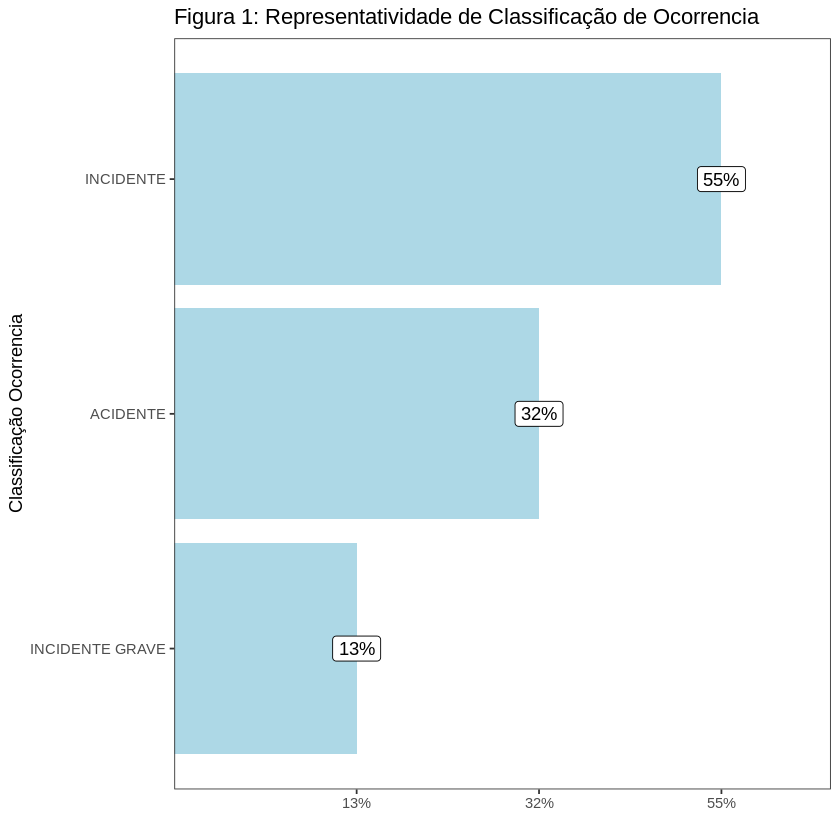

In [8]:
qtde_obs <- nrow(dados)

dados |>
        group_by(ocorrencia_classificacao) |>
        summarise(quantidade = percent(round(n()/qtde_obs,4))) |>
        ggplot(aes(x=fct_reorder(ocorrencia_classificacao,quantidade),y=quantidade,label=quantidade))  + 
        geom_bar(stat= "identity",fill = "lightblue") +
        geom_label() +
        coord_flip () +
        ggtitle("Figura 1: Representatividade de Classificação de Ocorrencia")+
        xlab("Classificação Ocorrencia") + ylab("") +
        theme_bw() +
        theme(axis.title.x = element_text(margin(t=8)),panel.grid=element_blank())

Neste primeiro gráfico é referente a variével target, onde é possível perceber que 55% dos dados são referentes a incidentes, e talvez por conta dessa proporção seja necessário tratativa para realizar a análise de classificação atráves da arvore de decisão. 

### **Tabelas Cruzadas**

In [9]:
CrossTable(dados$ocorrencia_saida_pista,dados$ocorrencia_classificacao,
           prop.r=TRUE, prop.c=TRUE, prop.t=FALSE, prop.chisq=FALSE, expected=TRUE,
           digits=2)


 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  5529 

 
                             | dados$ocorrencia_classificacao 
dados$ocorrencia_saida_pista |        ACIDENTE |       INCIDENTE | INCIDENTE GRAVE |       Row Total | 
-----------------------------|-----------------|-----------------|-----------------|-----------------|
                         NÃO |            1480 |            2993 |             529 |            5002 | 
                             |         1585.91 |         2751.15 |          664.94 |                 | 
                             |            0.30 |            0.60 |            0.11 |            0.90 | 
                             |            0.84 |            0.98 |            0.72 |                 | 
-----------------------------|-----------------|-----------------|-----------------|

In [10]:
CrossTable(dados$aeronave_tipo_veiculo,dados$ocorrencia_classificacao,
           prop.r=TRUE, prop.c=TRUE, prop.t=FALSE, prop.chisq=FALSE, expected=TRUE,
           digits=2)

Warning message in chisq.test(t, correct = FALSE, ...):
“Chi-squared approximation may be incorrect”



 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  5363 

 
                            | dados$ocorrencia_classificacao 
dados$aeronave_tipo_veiculo |        ACIDENTE |       INCIDENTE | INCIDENTE GRAVE |       Row Total | 
----------------------------|-----------------|-----------------|-----------------|-----------------|
                    ANFÍBIO |               6 |               6 |               0 |              12 | 
                            |            3.82 |            6.58 |            1.61 |                 | 
                            |            0.50 |            0.50 |            0.00 |            0.00 | 
                            |            0.00 |            0.00 |            0.00 |                 | 
----------------------------|-----------------|-----------------|-----------------|--------

In [11]:
CrossTable(dados$aeronave_motor_tipo,dados$ocorrencia_classificacao,
           prop.r=TRUE, prop.c=TRUE, prop.t=FALSE, prop.chisq=FALSE, expected=TRUE,
           digits=2)

Warning message in chisq.test(t, correct = FALSE, ...):
“Chi-squared approximation may be incorrect”



 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  5269 

 
                          | dados$ocorrencia_classificacao 
dados$aeronave_motor_tipo |        ACIDENTE |       INCIDENTE | INCIDENTE GRAVE |       Row Total | 
--------------------------|-----------------|-----------------|-----------------|-----------------|
                        0 |               2 |              10 |               1 |              13 | 
                          |            4.12 |            7.13 |            1.75 |                 | 
                          |            0.15 |            0.77 |            0.08 |            0.00 | 
                          |            0.00 |            0.00 |            0.00 |                 | 
--------------------------|-----------------|-----------------|-----------------|-----------------|
     

In [12]:
CrossTable(dados$aeronave_motor_quantidade,dados$ocorrencia_classificacao,
           prop.r=TRUE, prop.c=TRUE, prop.t=FALSE, prop.chisq=FALSE, expected=TRUE,
           digits=2)

Warning message in chisq.test(t, correct = FALSE, ...):
“Chi-squared approximation may be incorrect”



 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  5424 

 
                                | dados$ocorrencia_classificacao 
dados$aeronave_motor_quantidade |        ACIDENTE |       INCIDENTE | INCIDENTE GRAVE |       Row Total | 
--------------------------------|-----------------|-----------------|-----------------|-----------------|
                        BIMOTOR |             249 |            1875 |             241 |            2365 | 
                                |          748.22 |         1298.48 |          318.30 |                 | 
                                |            0.11 |            0.79 |            0.10 |            0.44 | 
                                |            0.15 |            0.63 |            0.33 |                 | 
--------------------------------|-----------------|------------

In [13]:
CrossTable(dados$aeronave_fase_operacao,dados$ocorrencia_classificacao,
           prop.r=TRUE, prop.c=TRUE, prop.t=FALSE, prop.chisq=FALSE, expected=TRUE,
           digits=2)

Warning message in chisq.test(t, correct = FALSE, ...):
“Chi-squared approximation may be incorrect”



 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  5500 

 
                                | dados$ocorrencia_classificacao 
   dados$aeronave_fase_operacao |        ACIDENTE |       INCIDENTE | INCIDENTE GRAVE |       Row Total | 
--------------------------------|-----------------|-----------------|-----------------|-----------------|
              APROXIMAÇÃO FINAL |              72 |             214 |              30 |             316 | 
                                |           99.45 |          174.37 |           42.17 |                 | 
                                |            0.23 |            0.68 |            0.09 |            0.06 | 
                                |            0.04 |            0.07 |            0.04 |                 | 
--------------------------------|-----------------|------------

In [14]:
CrossTable(dados$aeronave_tipo_operacao,dados$ocorrencia_classificacao,
           prop.r=TRUE, prop.c=TRUE, prop.t=FALSE, prop.chisq=FALSE, expected=TRUE,
           digits=2)


 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  5411 

 
                             | dados$ocorrencia_classificacao 
dados$aeronave_tipo_operacao |        ACIDENTE |       INCIDENTE | INCIDENTE GRAVE |       Row Total | 
-----------------------------|-----------------|-----------------|-----------------|-----------------|
                    AGRÍCOLA |             406 |              33 |              76 |             515 | 
                             |          164.85 |          282.10 |           68.05 |                 | 
                             |            0.79 |            0.06 |            0.15 |            0.10 | 
                             |            0.23 |            0.01 |            0.11 |                 | 
-----------------------------|-----------------|-----------------|-----------------|

In [15]:
CrossTable(dados$aeronave_nivel_dano,dados$ocorrencia_classificacao,
           prop.r=TRUE, prop.c=TRUE, prop.t=FALSE, prop.chisq=FALSE, expected=TRUE,
           digits=2)


 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  5481 

 
                          | dados$ocorrencia_classificacao 
dados$aeronave_nivel_dano |        ACIDENTE |       INCIDENTE | INCIDENTE GRAVE |       Row Total | 
--------------------------|-----------------|-----------------|-----------------|-----------------|
                DESTRUÍDA |             309 |               0 |               0 |             309 | 
                          |           97.14 |          170.76 |           41.10 |                 | 
                          |            1.00 |            0.00 |            0.00 |            0.06 | 
                          |            0.18 |            0.00 |            0.00 |                 | 
--------------------------|-----------------|-----------------|-----------------|-----------------|
     

In [16]:
CrossTable(dados$regiao,dados$ocorrencia_classificacao,
           prop.r=TRUE, prop.c=TRUE, prop.t=FALSE, prop.chisq=FALSE, expected=TRUE,
           digits=2)


 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  5525 

 
             | dados$ocorrencia_classificacao 
dados$regiao |        ACIDENTE |       INCIDENTE | INCIDENTE GRAVE |       Row Total | 
-------------|-----------------|-----------------|-----------------|-----------------|
CENTRO-OESTE |             376 |             329 |             156 |             861 | 
             |          272.71 |          473.74 |          114.54 |                 | 
             |            0.44 |            0.38 |            0.18 |            0.16 | 
             |            0.21 |            0.11 |            0.21 |                 | 
-------------|-----------------|-----------------|-----------------|-----------------|
    NORDESTE |             158 |             315 |              96 |             569 | 
             |       

In [17]:
CrossTable(dados$total_aeronaves_envolvidas,dados$ocorrencia_classificacao,
           prop.r=TRUE, prop.c=TRUE, prop.t=FALSE, prop.chisq=FALSE, expected=TRUE,
           digits=2)

Warning message in chisq.test(t, correct = FALSE, ...):
“Chi-squared approximation may be incorrect”



 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  5529 

 
                                 | dados$ocorrencia_classificacao 
dados$total_aeronaves_envolvidas |        ACIDENTE |       INCIDENTE | INCIDENTE GRAVE |       Row Total | 
---------------------------------|-----------------|-----------------|-----------------|-----------------|
                               1 |            1742 |            2997 |             715 |            5454 | 
                                 |         1729.22 |         2999.75 |          725.03 |                 | 
                                 |            0.32 |            0.55 |            0.13 |            0.99 | 
                                 |            0.99 |            0.99 |            0.97 |                 | 
---------------------------------|-----------------|----

### **Gráficos**

Gráfico contendo a informação a quantidade ocorrencias de acordo com a classificação e ocorrencia_saida_pista

`summarise()` has grouped output by 'ocorrencia_saida_pista'. You can override
using the `.groups` argument.
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


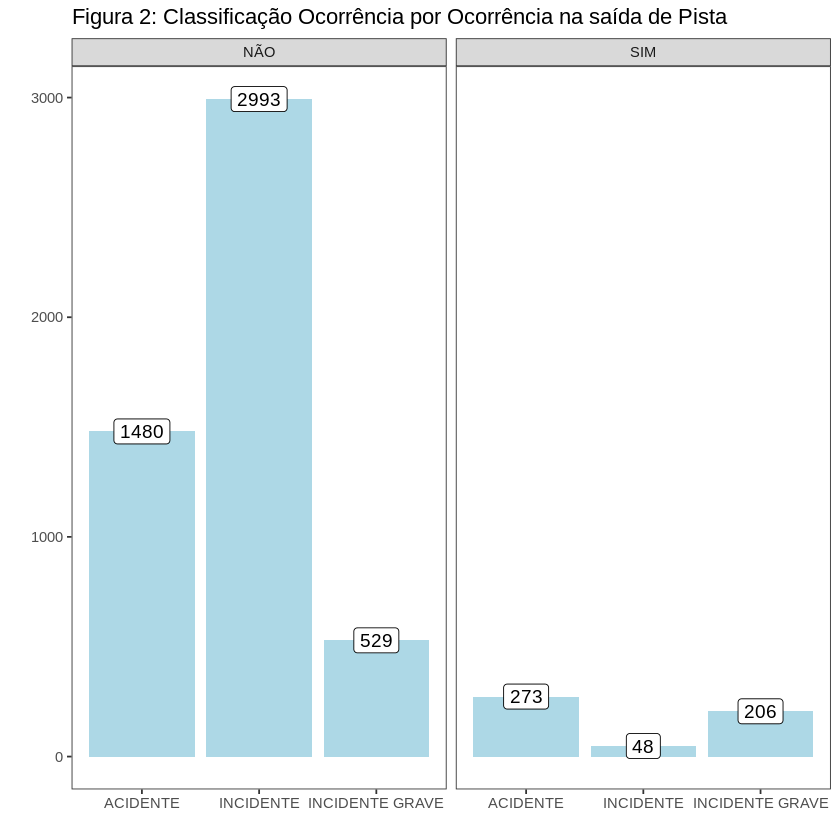

In [29]:
dados |>
        group_by(ocorrencia_saida_pista,ocorrencia_classificacao) |>
        summarise(quantidade = n()) |>
        ggplot(aes(x = ocorrencia_classificacao, y = quantidade,label= quantidade)) +
        geom_bar(stat="identity",fill = "lightblue") +
        facet_wrap(~ocorrencia_saida_pista,ncol=2) +
        geom_label(size=4)+
        xlab("") + ylab("") +
        theme_bw() +
        theme(axis.title.x = element_text(margin(t=10)),panel.grid=element_blank()) +
        ggtitle("Figura 2: Classificação Ocorrência por Ocorrência na saída de Pista")

Gráfico contendo a informação a quantidade ocorrencias de acordo com a classificação e tipo de veiculo

`summarise()` has grouped output by 'aeronave_tipo_veiculo'. You can override
using the `.groups` argument.
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
`summarise()` has grouped output by 'aeronave_tipo_veiculo'. You can override
using the `.groups` argument.
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
`summarise()` has grouped output by 'aeronave_tipo_veiculo'. You can override
using the `.groups` argument.
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


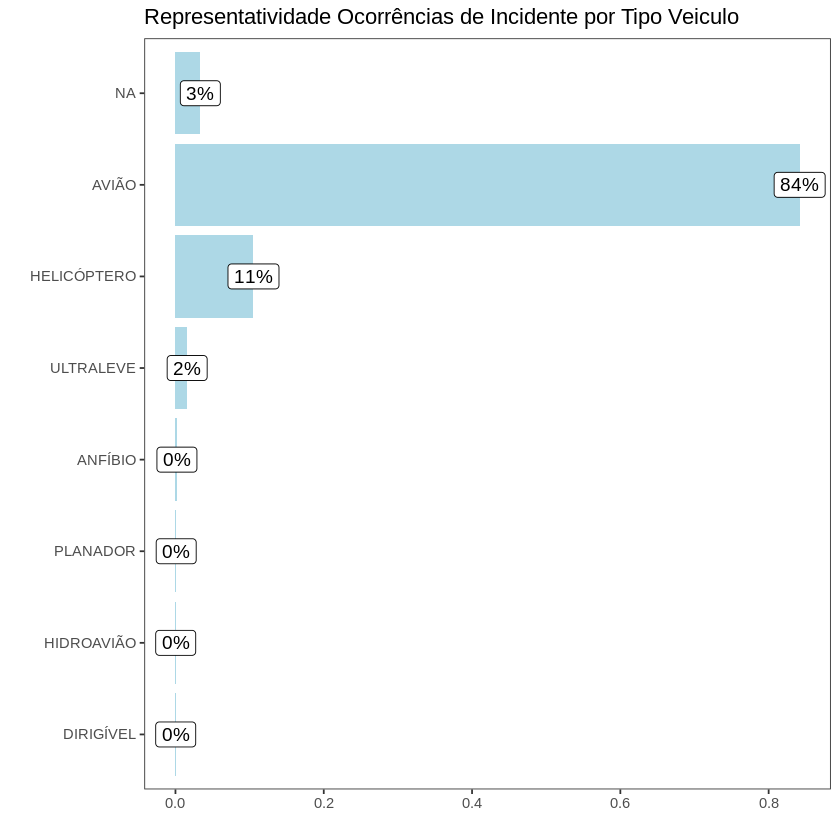

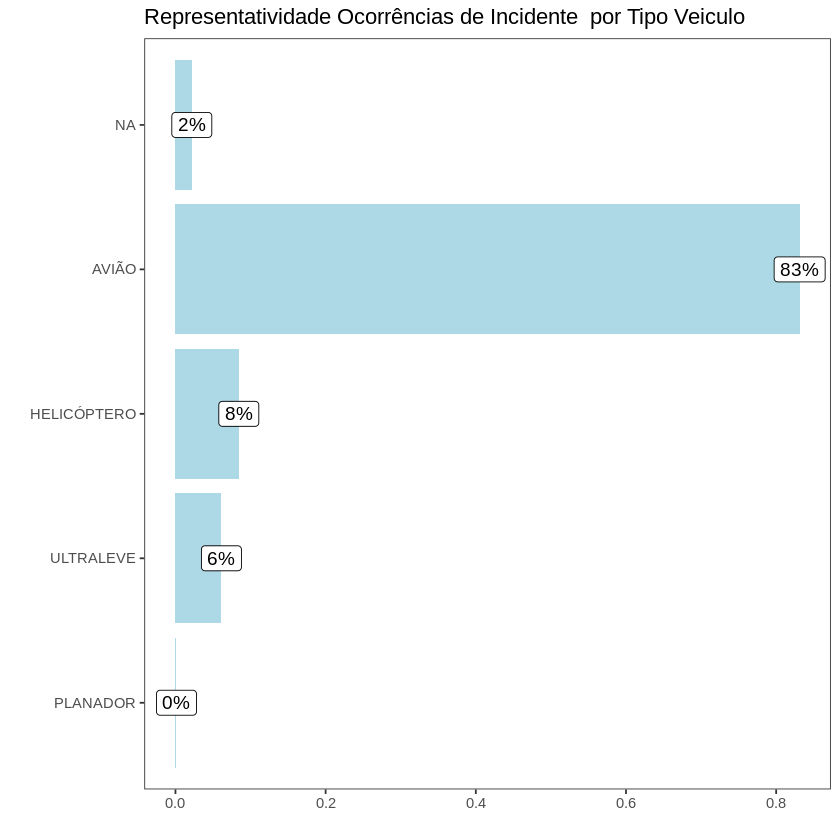

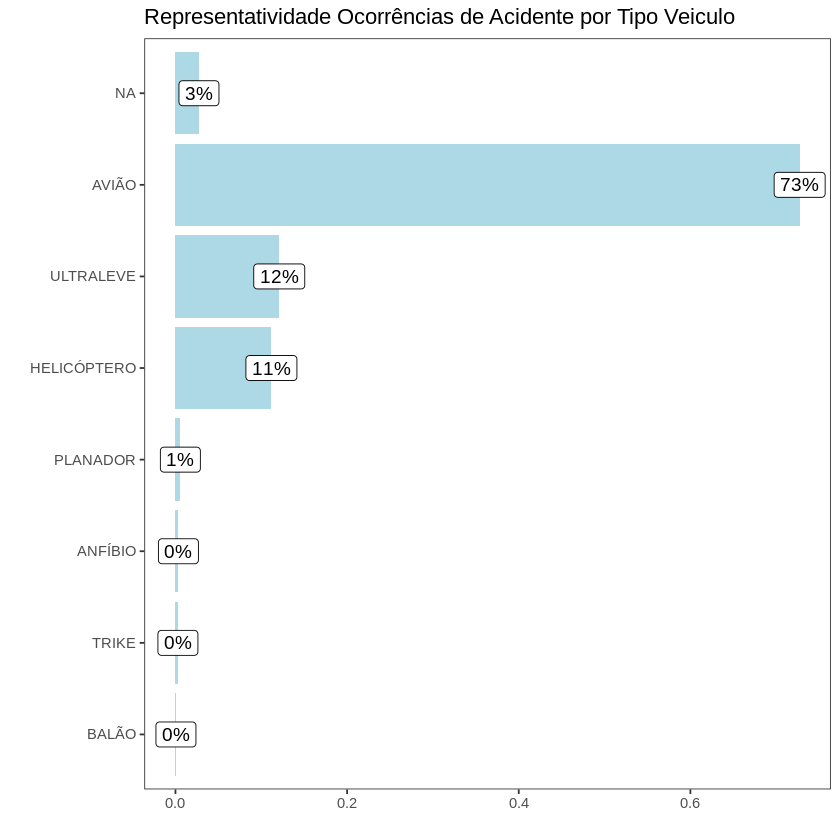

In [30]:
dados_acidente <- dados |> filter(ocorrencia_classificacao=="ACIDENTE")

qtde_obs_acidente <- nrow(dados_acidente)

graf_acidente <-  dados |> 
                  filter(ocorrencia_classificacao=="ACIDENTE") |>
                  group_by(aeronave_tipo_veiculo,ocorrencia_classificacao) |> 
                  summarise(quantidade = n()) |>
                  ggplot(aes(x = fct_reorder(aeronave_tipo_veiculo,quantidade/qtde_obs_acidente), y = quantidade/qtde_obs_acidente,label=                percent(round((quantidade/qtde_obs_acidente),2)))) +
                  geom_bar(stat="identity",fill = "lightblue") +
                  ggtitle("Representatividade Ocorrências de Acidente por Tipo Veiculo")+
                  coord_flip () +
                  geom_label(size=4)+
                  xlab("") + ylab("") +
                  theme_bw() +
                  theme(axis.title.x = element_text(margin(t=10)),panel.grid=element_blank()) 

dados_incidente <- dados |> filter(ocorrencia_classificacao=="INCIDENTE")

qtde_obs_incidente <- nrow(dados_incidente)

graf_incidente <-  dados |> 
                  filter(ocorrencia_classificacao=="INCIDENTE") |>
                  group_by(aeronave_tipo_veiculo,ocorrencia_classificacao) |> 
                  summarise(quantidade = n()) |>
                  ggplot(aes(x = fct_reorder(aeronave_tipo_veiculo,quantidade/qtde_obs_incidente), y = quantidade/qtde_obs_incidente,label=                percent(round((quantidade/qtde_obs_incidente),2)))) +
                  geom_bar(stat="identity",fill = "lightblue") +
                  ggtitle("Representatividade Ocorrências de Incidente por Tipo Veiculo")+
                  coord_flip () +
                  geom_label(size=4)+
                  xlab("") + ylab("") +
                  theme_bw() +
                  theme(axis.title.x = element_text(margin(t=10)),panel.grid=element_blank()) 

dados_incid_grave <- dados |> filter(ocorrencia_classificacao=="INCIDENTE GRAVE")

qtde_obs_incid_grave <- nrow(dados_incid_grave)

graf_incid_grave <-  dados |> 
                  filter(ocorrencia_classificacao=="INCIDENTE GRAVE") |>
                  group_by(aeronave_tipo_veiculo,ocorrencia_classificacao) |> 
                  summarise(quantidade = n()) |>
                  ggplot(aes(x = fct_reorder(aeronave_tipo_veiculo,quantidade/qtde_obs_incid_grave), y = quantidade/qtde_obs_incid_grave,label= percent(round((quantidade/qtde_obs_incid_grave),2)))) +
                  geom_bar(stat="identity",fill = "lightblue") +
                   ggtitle("Representatividade Ocorrências de Incidente  por Tipo Veiculo")+
                  coord_flip () +
                  geom_label(size=4)+
                  xlab("") + ylab("") +
                  theme_bw() +
                  theme(axis.title.x = element_text(margin(t=10)),panel.grid=element_blank())

##grid.arrange(graf_incidente, graf_incid_grave,graf_acidente,ncol=3)

graf_incidente
graf_incid_grave
graf_acidente


# **Árvore de decisão - Classificação**





Realizando a separação conjunto de dados entre treino e teste

In [12]:
set.seed(1234)

divisao_dados <- initial_split(data = dados,prop = 0.75)
dados_treino <- training(divisao_dados)
dados_teste <- testing(divisao_dados)

set.seed(1234)

cv <- vfold_cv(dados_treino, v = 10) 

Definindo a variável target e as variáveis independentes

In [13]:
receita    <- recipe(ocorrencia_classificacao ~ . , data = dados_treino)

##**Modelos**

Iremos iniciar com dois modelos (Rpart, C5.0), neste primeiro momento não iremos difinir parâmetros e nem utilizar validação cruzada.




### **RPART**

In [14]:
arv_rpart  <- decision_tree() |> 
              set_engine("rpart") |>
              set_mode("classification")

wf_rpart <- workflow() |> add_recipe(receita) |> add_model(arv_rpart)

modelo_ajustado_rpart <- fit(wf_rpart,dados_treino)


Exibindo o modelo de acordo com o metodo de Rpart

---



In [63]:
modelo_ajustado_rpart

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: decision_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
n= 4146 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 4146 1872 INCIDENTE (0.31789677 0.54848046 0.13362277)  
  2) aeronave_nivel_dano=DESTRUÍDA,SUBSTANCIAL 1409  157 ACIDENTE (0.88857346 0.02767921 0.08374734) *
  3) aeronave_nivel_dano=LEVE,NENHUM 2737  502 INCIDENTE (0.02411399 0.81658750 0.15929850)  
    6) ocorrencia_saida_pista=NÃO 2575  371 INCIDENTE (0.02291262 0.85592233 0.12116505) *
    7) ocorrencia_saida_pista=SIM 162   38 INCIDENTE GRAVE (0.04320988 0.19135802 0.76543210) *

Calculando a acuracia do modelo de acordo com dados de treino.

In [15]:
resultado_treino_rpart <- predict(modelo_ajustado_rpart,dados_treino)
resultado_treino_rpart <- mutate(resultado_treino_rpart,ocorrencia_classificacao=dados_treino$ocorrencia_classificacao)
resultado_treino_rpart |> metrics(ocorrencia_classificacao,.pred_class)



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8634829
kap,multiclass,0.7500110


Calculando a acuracia do modelo de acordo com os dados de teste.

In [16]:
resultado_teste_rpart <- predict(modelo_ajustado_rpart,dados_teste)
resultado_teste_rpart <- mutate(resultado_teste_rpart,ocorrencia_classificacao=dados_teste$ocorrencia_classificacao)
resultado_teste_rpart |> metrics(ocorrencia_classificacao,.pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8640636
kap,multiclass,0.7500298


#### **Analisando caracterticas do modelo rpart**





In [17]:
tree_fit <- modelo_ajustado_rpart |>
            extract_fit_parsnip()

Importancia das variaveis no modelo

Warning message:
“Ignoring unknown parameters: stat”


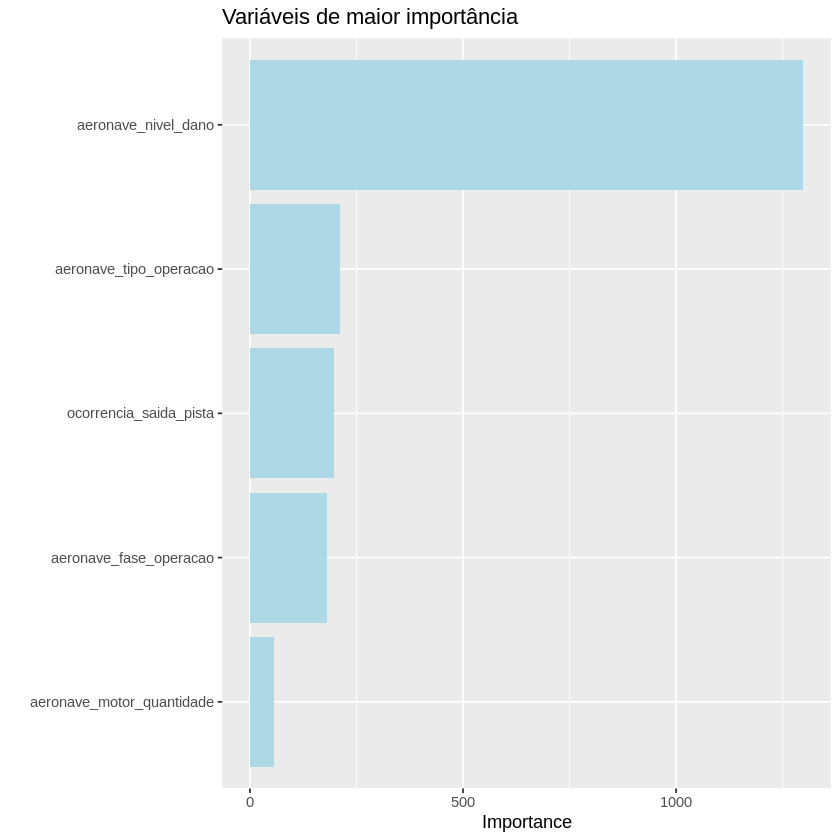

In [19]:
vip(tree_fit) +
geom_col(stat = "identity",fill="lightblue") +
ggtitle("Variáveis de maior importância")

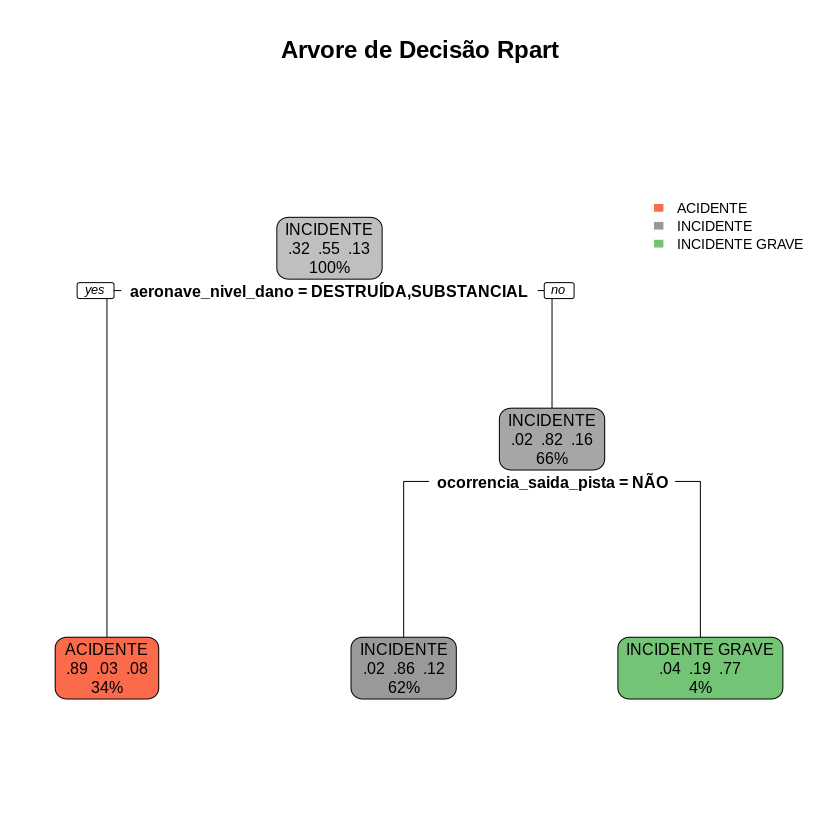

In [20]:
rpart.plot(tree_fit$fit, main = "Arvore de Decisão Rpart",
    tweak = 0.8,roundint=FALSE)

### **C5.0**

In [21]:
arv_c50   <-  decision_tree() |> 
              set_engine("C5.0") |>
              set_mode("classification")

wf_C50 <- workflow() |> add_recipe(receita) |> add_model(arv_c50)

modelo_ajustado_C50 <- fit(wf_C50,dados_treino)

c50 code called exit with value 1


Exibindo o modelo de acordo com o metodo de C5.0


In [22]:
modelo_ajustado_C50

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: decision_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
C5.0.default(x = x, y = y, trials = 1, control = C50::C5.0Control(minCases =
 2, sample = 0))

Classification Tree
Number of samples: 4146 
Number of predictors: 9 

Tree size: 0 

Non-standard options: attempt to group attributes


Não é possível realizar as outras etapas por não ter gerado nenhum modelo.

### **Procurando os melhores Hiperparametros**

#### **Rpart**

Iremos agora realizar grade de ajuste com combinações de valores de hiperparâmetros e neste momento utilizar o metodo de validação cruzada também.

In [31]:
arv_rpart_1  <- decision_tree(cost_complexity = tune(),
                            tree_depth = tune(),
                            min_n = tune()) |> 
              set_engine("rpart") |>
              set_mode("classification")

In [32]:
grade_parametros <- grid_regular(cost_complexity(),tree_depth(),min_n())
grade_parametros

cost_complexity,tree_depth,min_n
<dbl>,<int>,<int>
1.000000e-10,1,2
3.162278e-06,1,2
1.000000e-01,1,2
1.000000e-10,8,2
3.162278e-06,8,2
1.000000e-01,8,2
1.000000e-10,15,2
3.162278e-06,15,2
1.000000e-01,15,2


In [ ]:
set.seed(314)

wf <- workflow () |> add_model (arv_rpart_1) |> add_recipe (receita)

grade_ajustada <- tune_grid(wf, resamples = cv, grid = grade_parametros)

Visualizando os ajustes dos hiperparametros, atraves da medida de acurancia.

In [4]:
grade_ajustada |> show_best(metric = "accuracy")

ERROR: ignored

Treino completo de um modelo com os melhores valores de hiperparametro

In [5]:
melhor_wf <- select_best(grade_ajustada,metric = "accuracy")
melhor_wf <- wf |> finalize_workflow(melhor_wf)
ajuste_final <- melhor_wf |> last_fit(divisao_dados)

ajuste_final |> collect_metrics()

ERROR: ignored

In [ ]:
ajuste_final

In [ ]:
tree_fit2 <- ajuste_final |>
            extract_fit_parsnip()

In [ ]:
vip(tree_fit2) +
   ggtitle("Variáveis de maior importância")

In [ ]:
rpart.plot(tree_fit$fit2, main = "Arvore de Decisão Rpart",
    tweak = 0.8,roundint=FALSE)